<a href="https://colab.research.google.com/github/jepersson/DSND-P1-CoronaEDA/blob/master/CoronaEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corona EDA Notebook (draft)

With a lot of spare time due to the current corona pandemic I thought that this might be a great opportunity to get to "know your enemy" while also see if I could improve on some of the visualisations and metrics of the pandemic published every day in different news outlets.

As so many others that are writing about this topic I am not an expert in neither virology nor epidemiology, but since I felt that some of the visualisations and numbers reported on daily wasn't the best they could be I decided to see why I had this feeling. Also, there is no better way to understanding a topic than forcing yourself to go through some data connected with it.

I structured the text into three parts that I will guide you through in the order seen here below:

1. Initial exploration and answering the question of "Is the spreading out of control?"
2. Getting a birds eye view using choropleths and try to get to the bottom of "Is the reporting fair to compare between different countries?"
3. Scrathcing the surface to get out more details for a selected few countries while asking "Are the measures taken really helping?"

Before diving in there are a few assumptions and limitations we need to make clear.

* The text is based on data taken from European Centre for Disease Prevention and Control on 11th April 2020.
* To ease data cleanup and visualisation only the EU and some neigboring countries are considered.
* At the current time of writing the corona virus is estimated to have an death rate around 1-2% (statement based on reports from WHO presented on The Public Health Agency of Sweden's homepage)



## Importing modules and loading data

This section is possible to skip if you don't have the need to dig through what libraries and the details around how the data has been processed, it is also possible to use this section as a reference should there be any questions that come up reading the later parts of this text. 

Otherwise, feel free to continue starting with the relevant imports for this analysis.

In [0]:
# Capturing output to keep the notebook clean. Feel free to comment out 
# if you are curious
%%capture

# Import utils from base python
import math
import datetime
import itertools

# Import packages for handling data
import numpy as np
import pandas as pd

# Import packages for visualization and set style
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
plt.style.use('default')

# Install and import packages for handling maps as wel as
# supress warning about changing features in GeoPandas package
!apt install python3-rtree
!pip install geopandas

from rtree import index
from rtree.index import Rtree

import geopandas as gpd
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Make numbers in output easier to read
pd.options.display.precision = 2
pd.options.display.float_format = '{:,.2f}'.format

After the imports the next step is to get our hand on some data. The data used here is provided by the ECDC and can be found in the latest release [here](https://opendata.ecdc.europa.eu/covid19/casedistribution/csv). The data used in this analysis I have downloaded on the 11th of April 2020 and the code contains a direct link to the file in my google drive for ease of use. If you would like to update the notebook by yourself feel free to download the latest file and update the path accordingly. 

The following columns in the original data file will be used and are therefore imported and formated correctly:

* dateRep
* cases
* deaths
* countriesAndTerritories
* countryterritoryCode
* popData2018

In [2]:
# Define the path on google drive where the csv file is stored
path = ('https://drive.google.com/u/0/uc?id=1qCxFHRYvbG8MGqxqv_jMj2OIF2d3n02L&export=download')

# Use the above path to read in the csv
df = pd.read_csv(
    path, 
    # Pick out the columns useful for our analysis
    usecols=[
        'dateRep',
        'cases',
        'deaths',
        'countriesAndTerritories',
        'popData2018'
    ],
    # Parse the date in 'dateRep' to get correct dtype
    parse_dates=['dateRep'],
    date_parser=lambda x: datetime.datetime.strptime(x, "%d/%m/%Y"),
    # Give the other columns the correct dtypes as well
    dtype={
        'cases': 'Int32',
        'deaths': 'Int32',
        'countriesAndTerritories': 'str',
        'popData2018': 'Int32'
    })

# Displaying the original data being read from csv
df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018
0,2020-04-11,37,0,Afghanistan,37172386
1,2020-04-10,61,1,Afghanistan,37172386
2,2020-04-09,56,3,Afghanistan,37172386
3,2020-04-08,30,4,Afghanistan,37172386
4,2020-04-07,38,0,Afghanistan,37172386


As mentioned in the introduction contries in the EU and some of the neighbors will be the only targets to make data processing and visualization easier. These countries are filtered out, and data cleaning and proper column naming is done on the resulting data set.

In [3]:
# List of European countries that are part of the EU
eu_countries = [
  "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus",
  "Czech Republic", "Denmark", "Estonia", "Finland", "France", 
  "Germany", "Greece", "Hungary", "Ireland", "Italy", 
  "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", 
  "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", 
  "Spain", "Sweden", 'Iceland', 'Norway', 'Switzerland', 
  'United Kingdom'
]

# Filter out the rows in the file from the above countries
df = df[
  df['countriesAndTerritories']
  .str.replace('_', ' ')
  .str.lower()
  .str.title()
  .str.match('|'.join(eu_countries))
]

# Also let's rename all columns to something that is more presentable
df = df.rename(
    columns={
        'dateRep': 'Date',
        'cases': 'Cases',
        'deaths': 'Deaths',
        'countriesAndTerritories': 'Country',
        'popData2018': 'Population (2018)'
    }
)

# Clean up country naming
df['Country'] = df['Country'].str.replace('_', ' ')

# Check that the selected countries and resulting countries in df is the same
if df['Country'].unique().sort() == eu_countries.sort():
    print('Dataframe hae been filtered successfully.')
else:
    print('Dataframe filtering failed!!!')

Dataframe hae been filtered successfully.


Once the selected countries has been filtered out and verified one last verification of the whole dataframe is made to make sure there are no null values or faulty data types. As seen from the printout below this is not the case.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 567 to 9749
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2447 non-null   datetime64[ns]
 1   Cases              2447 non-null   Int32         
 2   Deaths             2447 non-null   Int32         
 3   Country            2447 non-null   object        
 4   Population (2018)  2447 non-null   Int32         
dtypes: Int32(3), datetime64[ns](1), object(1)
memory usage: 93.2+ KB


Having a quick look at the data there are still some format issues that needs to be corrected, for example there are zero case reports far further back in time than the first reported case in Europe. To keep only the necessary data rows reporting zero cases are thrown away.

In [5]:
# Throw away zero case reports
df = df.loc[df['Cases'] > 0]

# Show counts for all present dates
df['Date'].value_counts().sort_index()

2020-01-25     1
2020-01-28     1
2020-01-29     2
2020-01-30     2
2020-01-31     4
              ..
2020-04-07    30
2020-04-08    30
2020-04-09    30
2020-04-10    30
2020-04-11    30
Name: Date, Length: 67, dtype: int64

Data is present from the 25th of January 2020 up until the date of data retrieval, which is a feasible timespans.

Just to make sure that the data has been processed somewhat properly, and also to spot any offset in reporting or similar issues, a comparison between the three first countries with case reports in the EU and when these countries occur in the data is made.

In [6]:
# First data points for the EU countries with the first reported cases.
# (Information about first reported cases taken from Wikipedia on 11th of April)

selected_countries = [
    'France',
    'Germany',
    'Finland'
]

first_ocurrencies = {
    'France': '2020-01-24',
    'Germany': '2020-01-27',
    'Finland': '2020-01-29'
}

for country in selected_countries:
    first_case_date = df.loc[df['Country'] == country, 'Date'].min()
    print(f'# {country}')
    print(f'First case ocurred (source): {first_ocurrencies[country]}')
    print(f'First case reported (data): {first_case_date}')
    print(f'')

# France
First case ocurred (source): 2020-01-24
First case reported (data): 2020-01-25 00:00:00

# Germany
First case ocurred (source): 2020-01-27
First case reported (data): 2020-01-28 00:00:00

# Finland
First case ocurred (source): 2020-01-29
First case reported (data): 2020-01-30 00:00:00



Wikipedia articles used as sources for the comparison:

* [2020 coronavirus pandemic in France](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_France)
* [2020 coronavirus pandemic in Germany](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Germany)  
* [2020 coronavirus pandemic in Finland](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Finland)  

There is a lag of one day from occurence to reported date in our data so it seem as if it is being updated everyday with a summary of the preceeding days data. Also looking back at the counts for each date there is no fall in the number of datapoints for the last date so it should be safe to use all data points up until the date of retrieval.

Before starting the analysis minor adjustments are made adding cumulative sums for reported deaths and cases as well as creating the same amount of reported dates for all countries.

In [7]:
# Fill all dates without reports for all countries with zero case/death reports
df = (
    # Create dataframe with equal amount of dates for all countries
    df
    .set_index(
        ['Country', 'Date']
    )
    .reindex(
        pd
        .MultiIndex
        .from_product([
            df['Country'].unique(), 
            pd.date_range(df['Date'].min(), df['Date'].max())
        ],
        names=['Country', 'Date'])
    )
    # Fill all Null values created in the new dataframe with zeroes
    .fillna(
        value={
            'Cases': 0,
            'Deaths': 0,
        }
    )
    .fillna(
        method='bfill'
    )
    # Reset index to return back to the initial dataframe format
    .reset_index()
)

# Also, lets add accumulative values for the Date and Deaths columns
# They will come in handy later.
df = pd.concat(
    [df,
     (df.groupby('Country')
         [['Cases', 'Deaths']]
         # Doing som casting back and forth due to cumsum() 
         # not working with integers
         .transform(lambda x: x.astype(float).cumsum())
         .astype(int)
         .rename(columns={
             'Cases': 'Accumulated Cases',
             'Deaths': 'Accumulated Deaths'
         }))],
    axis=1
)

# Rearrange columns for increased readability
df = df[[
    'Country',
    'Date',
    'Cases',
    'Accumulated Cases',
    'Deaths',    
    'Accumulated Deaths',
    'Population (2018)'
]]

# Print out a sample of 5 rows from the resulting dataframe
df[50:55]

,Country,Date,Cases,Accumulated Cases,Deaths,Accumulated Deaths,Population (2018)
50,Austria,2020-03-15,151,655,0,1,8847037
51,Austria,2020-03-16,205,860,0,1,8847037
52,Austria,2020-03-17,156,1016,2,3,8847037
53,Austria,2020-03-18,316,1332,0,3,8847037
54,Austria,2020-03-19,314,1646,1,4,8847037


## Is the spreading out of control?

To start things of below are a visualisation not far from what many news outlets are presenting, either in numbers, graphs, or verbally by reporting with a focus on the number of cases in different countries around the world.

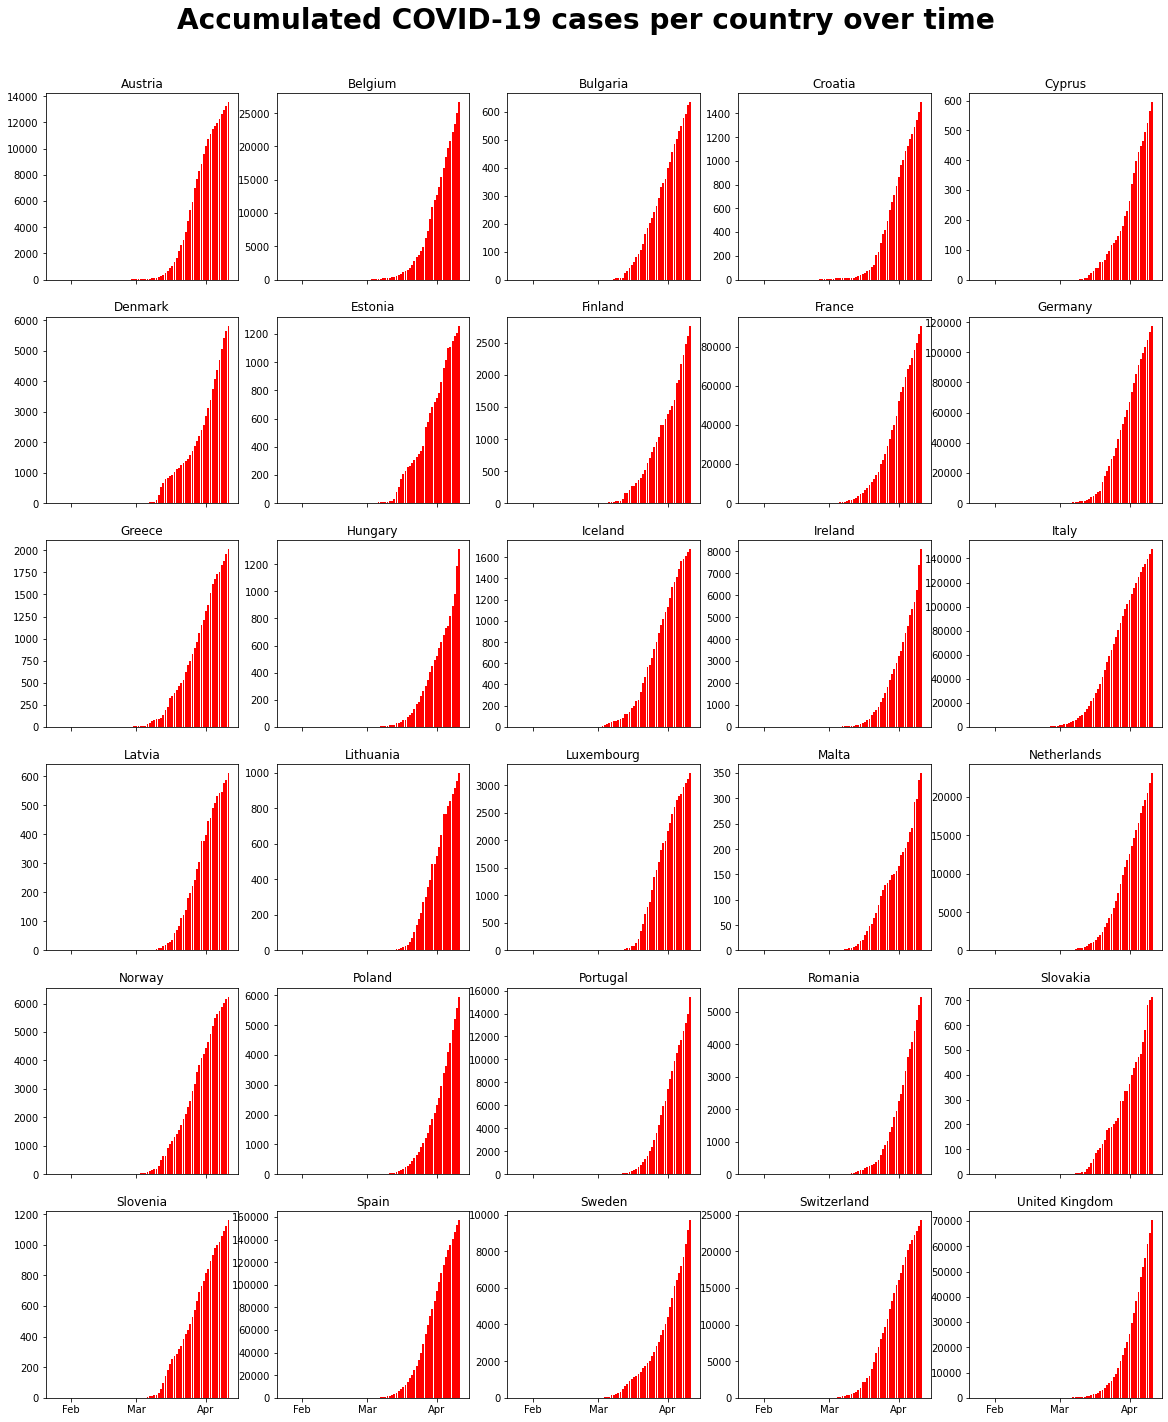

In [8]:
# Calculate necessary number of rows
nrows = math.ceil(len(eu_countries)/5.0) - 1

# Define subplot grid
fig, axs = plt.subplots(
    figsize=(20, nrows*4),
    nrows=nrows,
    ncols=5,
    sharex=True
)

# Set title for the whole figure
fig.suptitle(
    'Accumulated COVID-19 cases per country over time',
    fontsize=28,
    fontweight='bold',
    y=0.93
)

# Create subplots for each country
for country, ax in itertools.zip_longest(df['Country'].unique(), 
                                         itertools.chain.from_iterable(axs)):
    if country:
        # Filter out country and relevant fields from data
        country_df = df.loc[
            df['Country'] == country, 
            ['Date', 'Accumulated Cases']
        ]

        # Create base bar plot for country
        ax.bar(
            x='Date',
            height='Accumulated Cases',
            data=country_df,
            color='red'
        )

        # Set title on subplot
        ax.set_title(country)

        # Format the ticks on x axis to one each month
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        
    else:
        ax.axis('off') 

For once just looking at the color makes the situation feel ominous. Even though it is not good for the population at large, for many of us getting COVID-19 is far from a death sentence.

I can see the reasoning that reporting cold numbers without too much "mathemagics" being performed lowers the risk for spreading data that is misrepresented but it doesn't mean that you won't spread wrongfully drawn conclusion of the data you provide.

Just looking at this visuals our conclusion to the question "is the spreading out of control?" would be a quick and simple "YES!". But, is it really that simple? I suspect you already know my answer, otherwise this text would be far shorter in length.

By just changing the default in the following ways the outlook and the conclusions a reader might draw from the data presented changes drastically.

1. Stop signalling "DANGER!! DANGER!!" and switch the color scheme to something other than red. I think that this author on the [ArcsGIS Blog](https://www.esri.com/arcgis-blog/products/product/mapping/mapping-coronavirus-responsibly/) put it in a really good way "*We’re mapping a human health tragedy that may get way worse before it subsides. Do we really want the map to be screaming bright red?*"

2. To use a linear scale is certainly not to lie or embelish the truth but it does not give the context necessary for readers to understand the data properly. By using a linear scale, we also  expect the growth to be linear making the exponential growth we see in the early stage of an epidemic look like ragnarok is coming. There is a great explanation about why exponential growth is to be expected made by 3Blue1Brown over at [Youtube](https://youtu.be/gxAaO2rsdIs).

3. Lineing up multiple plots without fixing the y-axis makes it possible to show relevant information for each subplot itself but the small multiples pattern begs for comparing *between* subplots which is not easily done this way. The bars all showing the same escalating growth with the same amplitude does not help the overall impression.

Applying these improvement to the above worst case scenario plot gives the below slightly more nuanced results.

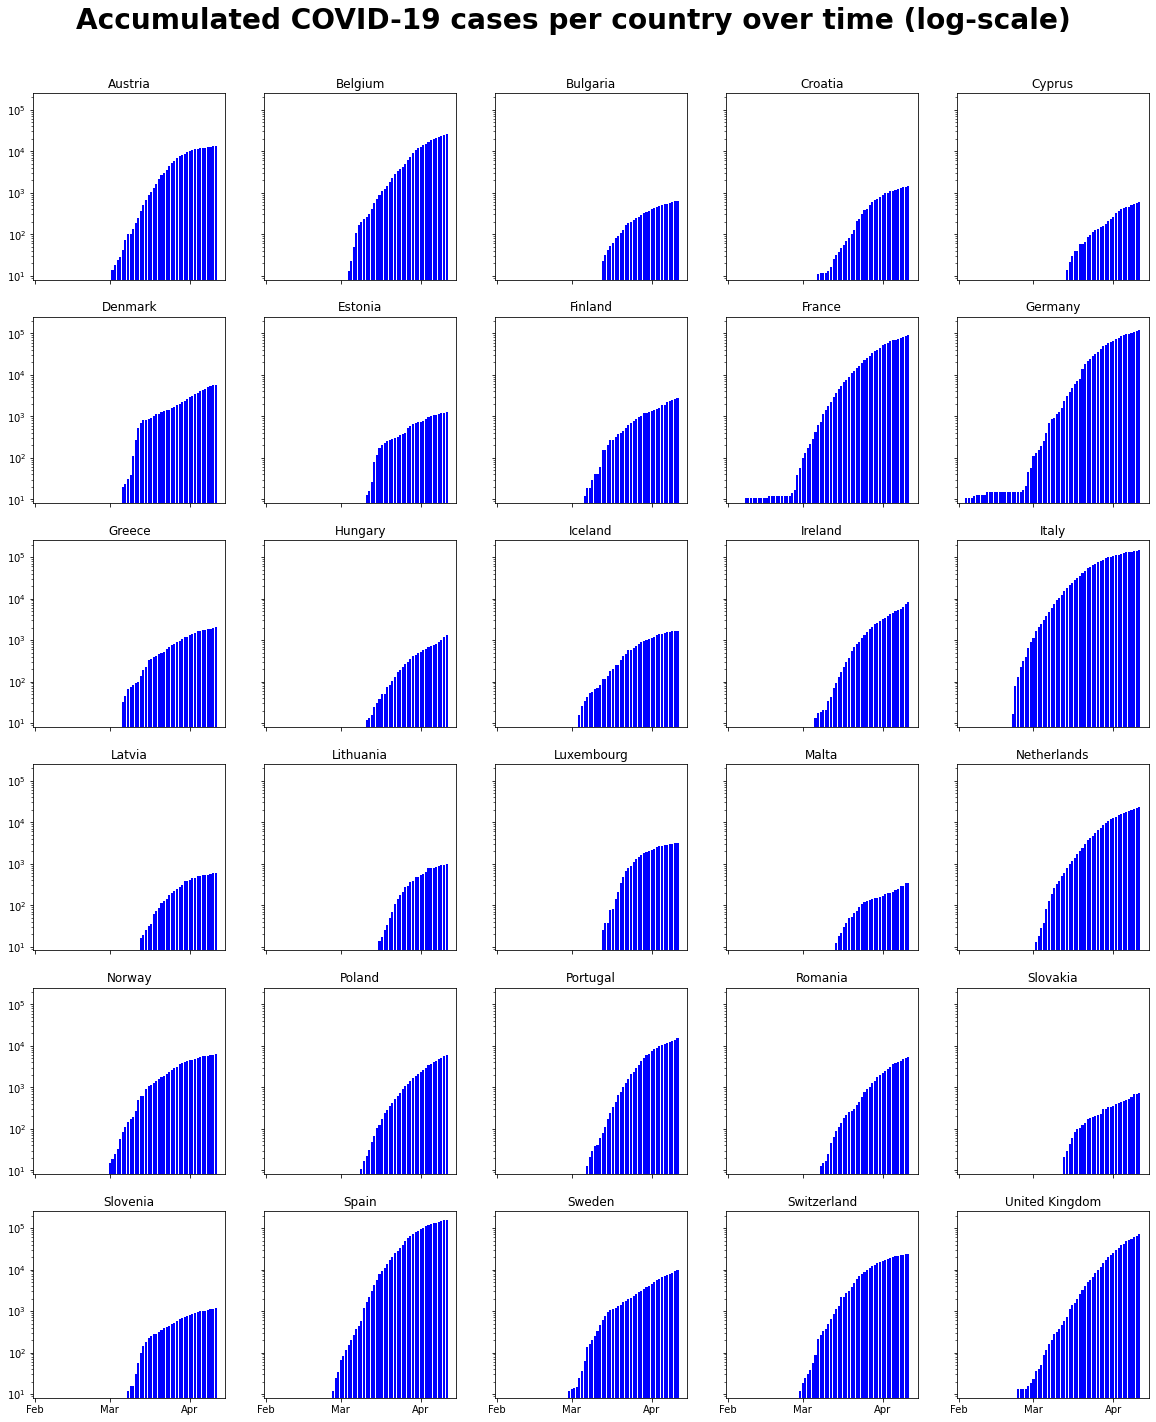

In [9]:
# Define subplot grid
fig, axs = plt.subplots(
    figsize=(20, nrows*4),
    nrows=nrows,
    ncols=5,
    sharex=True,
    # Share y axes as well
    sharey=True
)

# Set title for the whole figure, add mention about non-linear scale
fig.suptitle(
    'Accumulated COVID-19 cases per country over time (log-scale)',
    fontsize=28,
    fontweight='bold',
    y=0.93
)

# Create subplots for each country
for country, ax in itertools.zip_longest(df['Country'].unique(), 
                                         itertools.chain.from_iterable(axs)):
        if country:
            # Filter out country and relevant fields from data
            country_df = df.loc[
                df['Country'] == country, 
                ['Date', 'Accumulated Cases']
            ]

            # Create base bar plot for country
            ax.bar(
                x='Date',
                height='Accumulated Cases',
                # Clean out lower value counts to bring down noise
                data=country_df[country_df['Accumulated Cases'] > 10],
                color='blue',
                # Add log-scale to subplots
                log=True
            )

            # Format the ticks on x axis to one each month
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

            # Set title on subplot
            ax.set_title(country)

        else:
            ax.axis('off')

Given the changes still we see increases of the accumulated reported cases across the board but we can also see that the pace is slowing down in most countries we chosen to look at here.

At least judging from the reported confirmed cases there aren't any countries here that are clearly "out of control" but there is also a couple of issues with the use of reported cases that we will look more at in the next part.


## Is comparisons fair between countries?

It was touched upon in the previous section that the comparing different countries is somewhat of an instinctive reaction in all of us given a situation like this. People are looking at their neighboring countries and are evaluating their own government in the light of how they are behaving. Questions are raised such as "If we have as many reported cases as them, why wont we take harder measures to stop the virus from spreading?". 

As I already hinted about there are issues with looking too much at just reported cases. Let's start off with another example of a visualization that aren't that unsual, a choropleth comparing reported cases in different countries. 

oh, and once again the [ArcGIS Blog](https://www.esri.com/arcgis-blog/products/product/mapping/mapping-coronavirus-responsibly/) mentioned before has some very good thoughts about the most common faults being made in map visualizations. 

### Preparing the map visualizations

The initial part of this section is possible to skip if you aren't concerned with the details regading import the necessary map shape file, creating a mask and instatiating a GeoPandas dataframe containing our data.

So, a shape-file containing outlines for all countries in the world is being used from [Natural Earth Data](https://www.naturalearthdata.com) with an equal area projection for the European Terrestial Reference System. This will be crucial for the choropleth map we are creating since using  map projection were some countries sizes are exagerated also will exaggerate the visual representation of the area where cases are reported. The chosen projection also seems to be [recommended by the EU](https://inspire.ec.europa.eu/forum/pages/view/27639/workshop-map-projections-for-europe) for statistical and analytical purposes.

The below code imports the shape-file, creates a mask over Europe and then clips out the part of the shape file inside the mask boundaries. The results can be seen below.

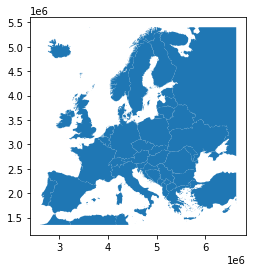

In [10]:
# Read in world map shape file from natural earth data for map visuals.
# (www.naturalearthdata.com)
world_map = (
    gpd
    .read_file(
        'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
    )
    # Setting projection to an equal-area projection for the European Terrestial 
    # Reference System.
    .to_crs('EPSG:3035')
)

# Create a custom polygon for the eu boundary
polygon = Polygon([
    (2550000.00, 1350000.00), 
    (6630000.00, 1350000.00), 
    (6630000.00, 5400000.00), 
    (2550000.00, 5400000.00)
])
eu_boundary = (
    gpd
    .GeoDataFrame(
        [1], 
        geometry=[polygon],
        crs=world_map.crs
    )
)

# Clip the european boundry from the world map
europe_map = (
    gpd
    .clip(world_map, eu_boundary)
    # Use a Lambert Azimuthal Equal Area projection for 
    # the European Terrestrial Reference System 1989 (EPSG:9820)
    # for equal area representation when plotting
    # .to_crs('EPSG:3035')
)

# Verify the map clipping
europe_map.plot();

After creating the mask the original dataframe is used to create a [GeoPandas](https://geopandas.org/index.html) dataframe enhanced with shape geometries from the mask made. 

In [11]:
# Create a GeoDataFrame for making the map
gdf = gpd.GeoDataFrame(
    df.merge(
        europe_map[[
            'NAME_EN',
            'geometry'
        ]],
        left_on='Country',
        right_on='NAME_EN'
    )
    .drop('NAME_EN', axis=1),
    geometry='geometry'
)

# Make sure all countries are still present and geometries has been added
if ((gdf['Country'].unique().sort() == df['Country'].unique().sort())
    & (~gdf['geometry'].isnull().values.any())):
    print('GeoDataframe has been created successfully.')
else:
    print('GeoDataframe creation failed!!!')

GeoDataframe has been created successfully.


###  


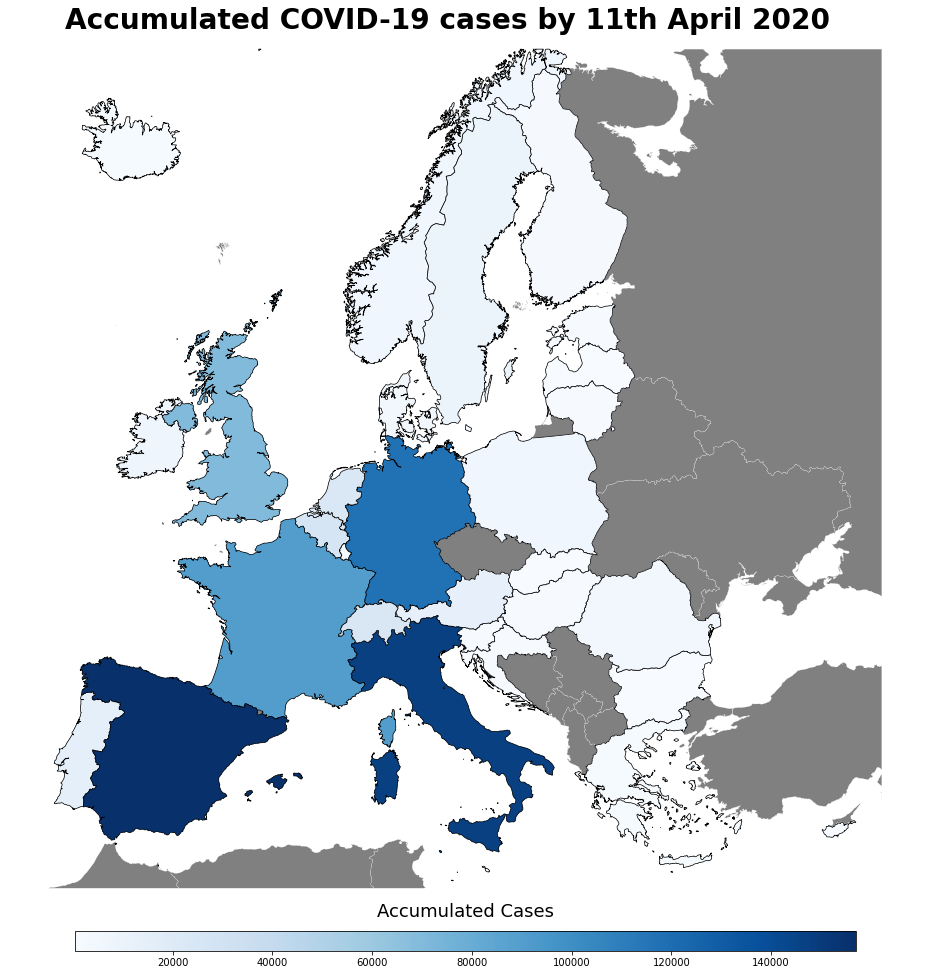

In [12]:
# Create figure grid
fig, ax = plt.subplots(figsize=(20, 20))

# Set figure title
fig.suptitle(
    'Accumulated COVID-19 cases by 11th April 2020',
    fontsize=28,
    fontweight='bold',
    y=0.88
)

# Create base background plot
europe_map.plot(
    ax=ax, 
    color='grey', 
    edgecolor='white', 
    linewidth=0.2
)

# Create plot with reported cases
gdf[gdf['Date'] == gdf['Date'].max()].plot(
    column='Accumulated Cases', 
    ax=ax, 
    edgecolor='black', 
    linewidth=0.7,
    cmap='Blues'
)

# Hide axes in figure
ax.set_axis_off()

# Colorbar creation and styling
(
    plt
    .colorbar(
        # Add colorbar to figure
        ax.collections[1], 
        ax=ax,
        orientation='horizontal',
        shrink=0.7,
        pad=0.001,
        aspect=40
    )
    .set_label(
        'Accumulated Cases', 
        size=18,
        # Pushing the label on the top of the colorbar
        labelpad=-65
    )
);

Here I have choosen to represent the number of reported cases with a choropleth map here but I know that for example the [John Hopkins COVID-19 dashboard](https://coronavirus.jhu.edu/map.html) are using the very similar proportional symbol map as well.

Using maps as a visualization tool is great for getting a good picture of how a phenomena or behaviour is changing based on location but there are also some caveats necessary to keep into consideration when using them.

The relationship between the area being represented and the value being shown are linked and can sometimes give unintended consequences. As in the above choropleth where the Benelux area (these countries aren't the only ones I believe however) is being shown in a very ligth shade on the color scale even though the number of reported cases compared to their actual size are higher than other neighboring countries. This is why you should always be a bit cautious any time you see absolute numbers on a map. 

Rather than representing the number of cases in absolute numbers a relative number such as reported cases per 1,000,000 citizens is much more fair in comparing between countries and when plotting data onto a map.

One other country that stands out is Germany, which isn't really seen as a country standing out currently but that here seems to have reoprted cases in the same order as Spain and Italy that we know have been hit hard by the corona virus. How could this be?

The answer is probably simpler than you think. The key is in the fact that what we are looking at here, and what is also being reported on in general, is the number of *reported* cases not the actual cases. Actually the reported cases are far from what is actually going on, shifting together with holidays, the workload of the healt care system, which country, and also depending on the country government's current policy for testing patients.

One possible measure to counter these differences between countries is to estimate the number of cases based on the reported number of deaths in each area. Currently, [The Public Health Agency](https://www.folkhalsomyndigheten.se/the-public-health-agency-of-sweden/communicable-disease-control/covid-19/) of Sweden is communicating an estimate of 1-2% in mortality rate so to get a low estimate we could use the number of deaths times a hundred as a proxy for the number of estimated total cases in a country.

A map with these changes would look something like the map below.

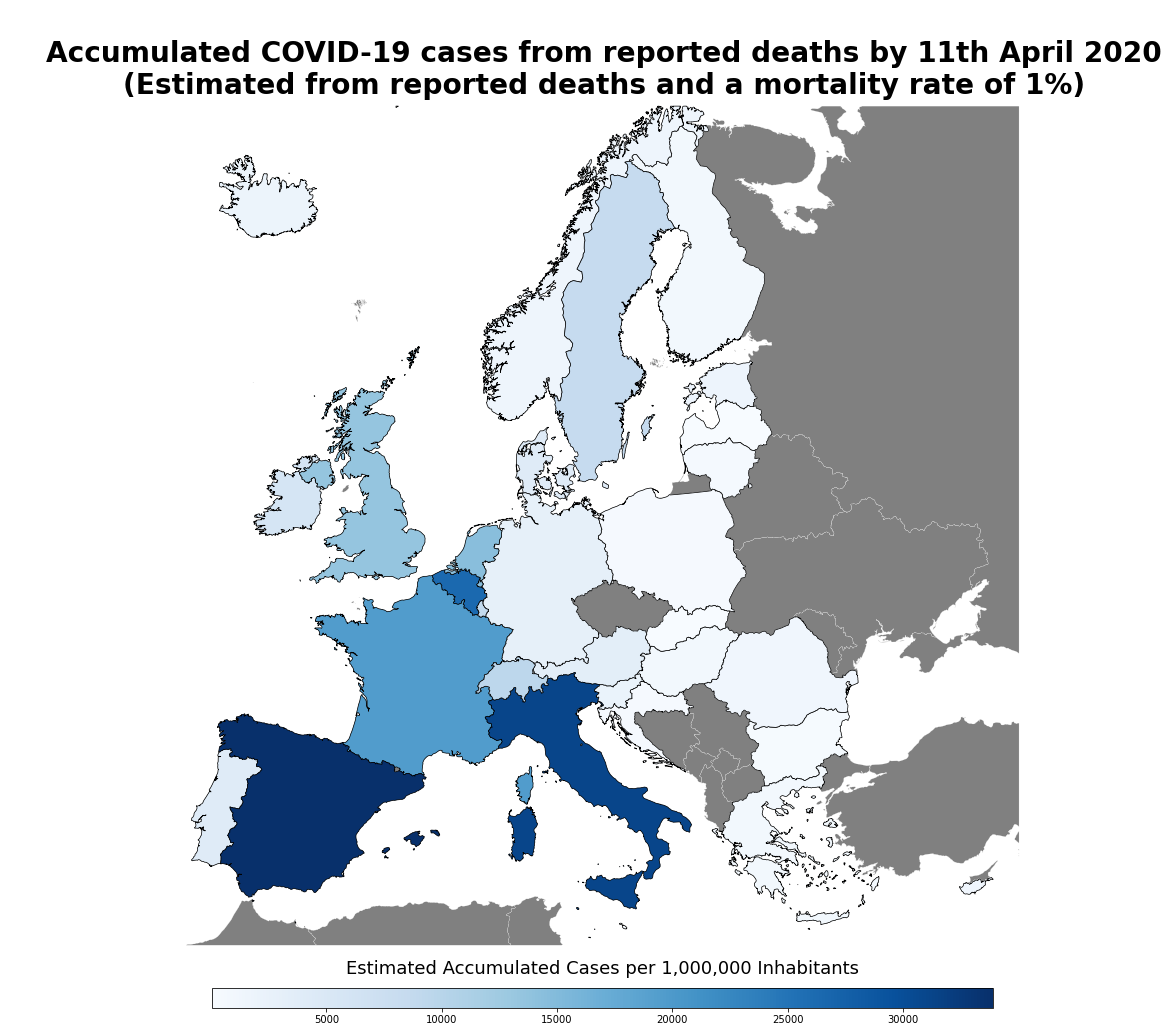

In [13]:
# Create figure grid
fig, ax = plt.subplots(figsize=(20, 20))

# Estimate Corona based on a lower end 1% mortality rate
# Source: https://www.folkhalsomyndigheten.se/the-public-health-agency-of-sweden/communicable-disease-control/covid-19/
gdf['Estimated Accumulated Cases per 1,000,000 Inhabitants'] = (
    (100 * gdf['Accumulated Deaths']) / (gdf['Population (2018)'] / 1000000.0)
)

# Set figure title
fig.suptitle(
    '''
    Accumulated COVID-19 cases from reported deaths by 11th April 2020
    (Estimated from reported deaths and a mortality rate of 1%)
    ''',
    fontsize=28,
    fontweight='bold',
    y=0.92
)

# Create base background plot
europe_map.plot(
    ax=ax, 
    color='grey', 
    edgecolor='white', 
    linewidth=0.2
) 

# Create plot with reported cases
gdf[gdf['Date'] == gdf['Date'].max()].plot(
    column='Estimated Accumulated Cases per 1,000,000 Inhabitants', 
    ax=ax, 
    edgecolor='black', 
    linewidth=0.7,
    cmap='Blues'
)

# Hide axes in figure
ax.set_axis_off()

# Colorbar creation and styling
(
    plt
    .colorbar(
        # Add colorbar to figure
        ax.collections[1], 
        ax=ax,
        orientation='horizontal',
        shrink=0.7,
        pad=0.001,
        aspect=40
    )
    .set_label(
        'Estimated Accumulated Cases per 1,000,000 Inhabitants', 
        size=18,
        # Pushing the label on the top of the colorbar
        labelpad=-65
    )
);

With the changes being made the map looks a bit different and we can see that for example the Benlux area have become darker now when the number of number of inhabitants isn't skewing the visual represantation. Also, since the virtualization is being based on our proxy estimates from number of deaths rather than the reported confirmed cases Germany's push for testing as many people they can is not giving them a worse representation than what their reality looks like.

To circle back to the question if it is fair to compare between countries hopefully this have shed some light on a few of the issues there are when comparing numbers between countries. There are of course many more confounding factors than the easily spotted once I mentioned here. 

Maybe it would be more fair in this stage, while the virus isn't widely spread in the whole of Europe to look at smaller regions inside every country? Should you look at population density? Or maybe there should be taken into consideration the cultural aspects influencing social connections between generations, such as elderly living together with their kids families and/or taking care of their grandchildren?

Sometimes in reporting you hear about the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number), or $ R_0 $, which is estimated somewhere between everything from 1,4-5,7. What is important to remember that the actual reproduction number out in the real world is affected by all the above mentioned factors and measures such as isolation, social distancing, and proper handwashing all affect the true rate at which the virus is spreading. This might be one reason why there aren't any blanket recommendations rather than fairly basic ones such as taking care of personal hygiene and protecting risk groups. How an outbreak will unfold all dependes on where and to whom it is happening to.

While this might not be such an incouraging conclusion it might be good to keep in the back of our heads before drawing too quick conclusion from oversimplified comparison between populations that might be living in totally different environments.

## Are the measures taken really helping?

Now for the last question, if the measures taken are helping or not? Of course this isn't a question that is easy to answer as there are many confounding factors as well as the fact that the spreading will subside by itself given time (it is impossible to infect *more* than the whole population in a country). However, with the aim to see if there are any change in the spreading of the virus before and after different measures such as lockdowns have taken place we should at least be able to evaluate if there are any observed effects or not.

First, in order to support our question it is necessary to create some additional metrics. By creating alternative timelines based on days after the day reported cases went over 100 cases, or the number of reported deaths went over 10 deaths we can get a better view of when the spreading "took off" and also create a viewpoint in which it is easier to make comparisons between countries.

In [14]:
df['Days since outbreak (+100 cases)'] = (
    df
    # Create threshold flag for when the death count exceeds 10
    .assign(
        threshold=[True 
                   if x >= 100
                   else False 
                   for x 
                   in df['Accumulated Cases']]
    )
    # Count up the occurences (days) per Country from when cases exceeded 
    # the threshold
    .groupby(['Country'])
    ['threshold']
    .cumsum()
)

df['Days since outbreak (+10 deaths)'] = (
    df
    # Create threshold flag for when the death count exceeds 10
    .assign(
        threshold=[True 
                   if x >= 10 
                   else False 
                   for x 
                   in df['Accumulated Deaths']]
    )
    # Count up the occurences (days) per Country from when cases exceeded 
    # the threshold
    .groupby(['Country'])
    ['threshold']
    .cumsum()
)

df.describe()

,Cases,Accumulated Cases,Deaths,Accumulated Deaths,Population (2018),Days since outbreak (+100 cases),Days since outbreak (+10 deaths)
count,"2,340.00","2,340.00","2,340.00","2,340.00","2,340.00","2,340.00","2,340.00"
mean,318.93,"4,234.80",29.42,309.86,"17,225,737.37",6.48,2.86
std,"1,068.66","16,872.77",133.16,"1,675.84","22,931,835.90",10.32,6.82
min,0.00,0.00,0.00,0.00,"353,574.00",0.00,0.00
25%,0.00,0.00,0.00,0.00,"2,789,533.00",0.00,0.00
50%,1.00,9.00,0.00,0.00,"7,770,379.50",0.00,0.00
75%,67.25,692.00,1.00,6.00,"17,231,017.00",11.00,0.00
max,"9,222.00","157,022.00","2,004.00","18,851.00","82,927,922.00",48.00,46.00


Above we can see the there are now two columns containing the days since the outbreak "started" defined either as reported cases going over 100 or reported deaths going over 10 respectively.

But in order to evalute the measures we talked about we also need data on which measures have been taken. Luckily I found this [paper with interventions](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-Europe-estimates-and-NPI-impact-30-03-2020.pdf) which I used in the below plots over the number of cases and deaths in Sweden, Denmark, Germany, and Italy up until 50 days after the first 100 cases were registered.

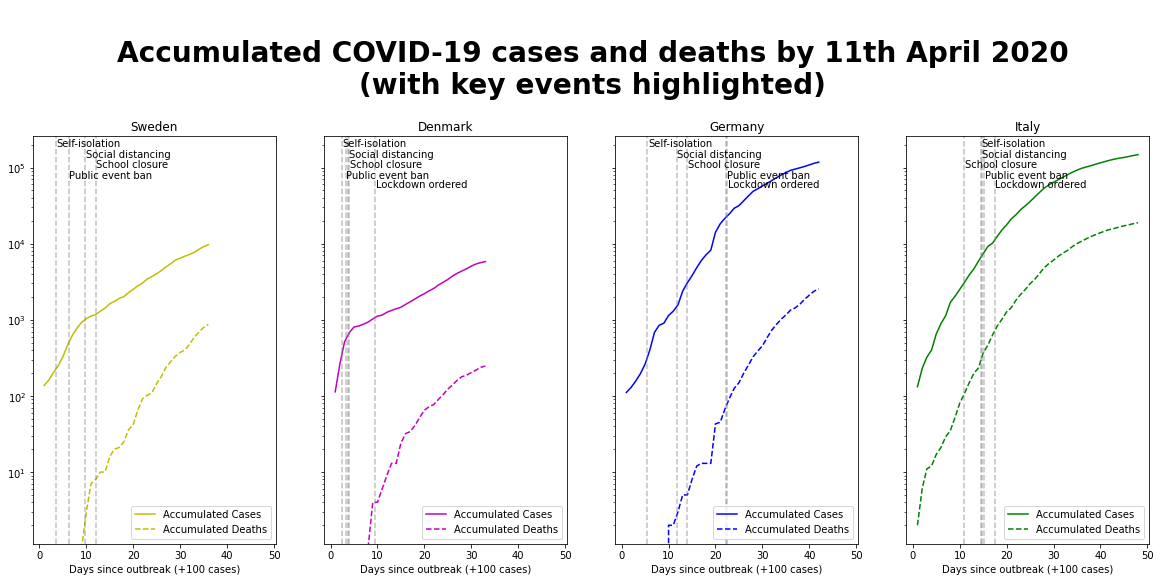

In [15]:
# Define selected countries to look at
selected_countries = [
                      'Sweden',
                      'Denmark',
                      'Germany',
                      'Italy'
]

# Define line styles for each country
country_style = {
    'Sweden' : ['y-', 'y--'],
    'Denmark' : ['m-', 'm--'],
    'Germany' : ['b-', 'b--'],
    'Italy' : ['g-', 'g--'],
}

# Define dates for major events in each selected country
country_events = {
    'Sweden': {
        'School closure':    '2020-03-18',
        'Public event ban':  '2020-03-12',
        'Social distancing': '2020-03-16',
        'Self-isolation':    '2020-03-10'
    },
    'Denmark': {
        'School closure':    '2020-03-13',
        'Public event ban':  '2020-03-12',
        'Lockdown ordered':  '2020-03-18',
        'Social distancing': '2020-03-13',
        'Self-isolation':    '2020-03-12'
    },
    'Germany': {
        'School closure':    '2020-03-14',
        'Public event ban':  '2020-03-22',
        'Lockdown ordered':  '2020-03-22',
        'Social distancing': '2020-03-12',
        'Self-isolation':    '2020-03-06'
    },
    'Italy': {
        'School closure':    '2020-03-05',
        'Public event ban':  '2020-03-09',
        'Lockdown ordered':  '2020-03-11',
        'Social distancing': '2020-03-09',
        'Self-isolation':    '2020-03-09'
    }
}

# Adjust positioning of event markers for increased readability
event_offset = {
        'Self-isolation':     [-0.5, 0],
        'Social distancing':  [-0.25, -65000],
        'School closure':     [0, -110000],
        'Public event ban':   [0.25, -147000],
        'Lockdown ordered':   [0.5, -170000]
}

# Define subplot grid
fig, axs = plt.subplots(
    figsize=(20, 7.5),
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    # Always return a 2d-array
    squeeze=0
)


# Set figure title
fig.suptitle(
    '''
    Accumulated COVID-19 cases and deaths by 11th April 2020
    (with key events highlighted)
    ''',
    fontsize=28,
    fontweight='bold',
    y=1.12
)

# Generate plots
for country, ax in zip(selected_countries, 
                       itertools.chain.from_iterable(axs)):
    # Set plot title
    ax.set_title(country)
    # Create base plot over accumulated number of cases and deaths
    (
        df[(df['Country'] == country) 
           & (df['Days since outbreak (+100 cases)'] > 0)]
        .pivot_table(
            index='Days since outbreak (+100 cases)',
            columns='Country',
            values=['Accumulated Cases', 'Accumulated Deaths']
        )
        .plot(
            logy=True,
            ax=ax,
            style=country_style[country]
        )
    )
    # Label dates for important events
    for event, date in country_events[country].items():
        # Plot event marker line
        ax.axvline(
            df.loc[
                (df['Country'] == country) & (df['Date'] == date),
                'Days since outbreak (+100 cases)'
            ].values + event_offset[event][0],
            linestyle='--',
            color='grey',
            alpha=0.5
        )
        # Plot event marker label
        ax.text(
            df.loc[
                (df['Country'] == country) & (df['Date'] == date),
                'Days since outbreak (+100 cases)'
            ].values + event_offset[event][0] + 0.1,
            240000 + event_offset[event][1], 
            event, 
            verticalalignment='top',
            horizontalalignment='left'
        )
        # Style plot legend
        ax.legend(
            ['Accumulated Cases', 
             'Accumulated Deaths'],
            loc='lower right'
        )

The reason why I choose exactly these four countries is due to the different approaches all four have had towards fighting the coronavirus. 

Some obvious differences is the fact that Sweden still haven't gone as far as issuing a lockdown despite the fact that the number of reported cases and deaths are higher than the neigboring country Denmark. Further Sweden and Denmark has a very abrupt change in the increase of reported cases most likely due to the policy to not try to test as many people in the population as possible but rather focusing on doing more targeted testing. In contrast Germany have had a more liberal approach to who is getting tested in order to try to get a better view of the situation which also resulted in the effect we saw in the map visualisation where Germany had a comparatively high case count. 

It is important to keep in mind that testing and reporting policies plays a big role in how the data is shaped and I found an explanation of this published over at [fivethirtyeight](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless) particulary helpful in gathering all the different effects and pitfalls there are related to this.

Turning the view to the core of our question, if the mesures taken have any effect, we can see that at least for the countries issuing lockdowns there have been a decrease in new cases but I bet that it is not as dramatic as many of us laymen would have thought. The early measures such as closing schools, promoting self-isolation, and banning public events doesn't seem to have had any drastic effect on the number of cases reported more than slowing down the rate in which they appear, something that is not to be underestimated since the number of cases that needs intensive care at one point in time is what could break the medical system in one country in this situation.

We can also only wonder what effects the lockdown itself has on the unrecorded cases as well as the rubberband effect it will have on the number of cases once the countries in lockdown starts to open up again. Since the three above countries all have started to ease their restrictions on the public we will probably see how successful the different measures were in a couple of weeks time.

All in all I believe that the short and simple answer to this, and all of these questions posed, is that it depends on your assumptions made and we just have to wait and see before we can say what would have been the right answer. By that time however it will be too late for this time, but hopefully it will be a good lesson learned for next.

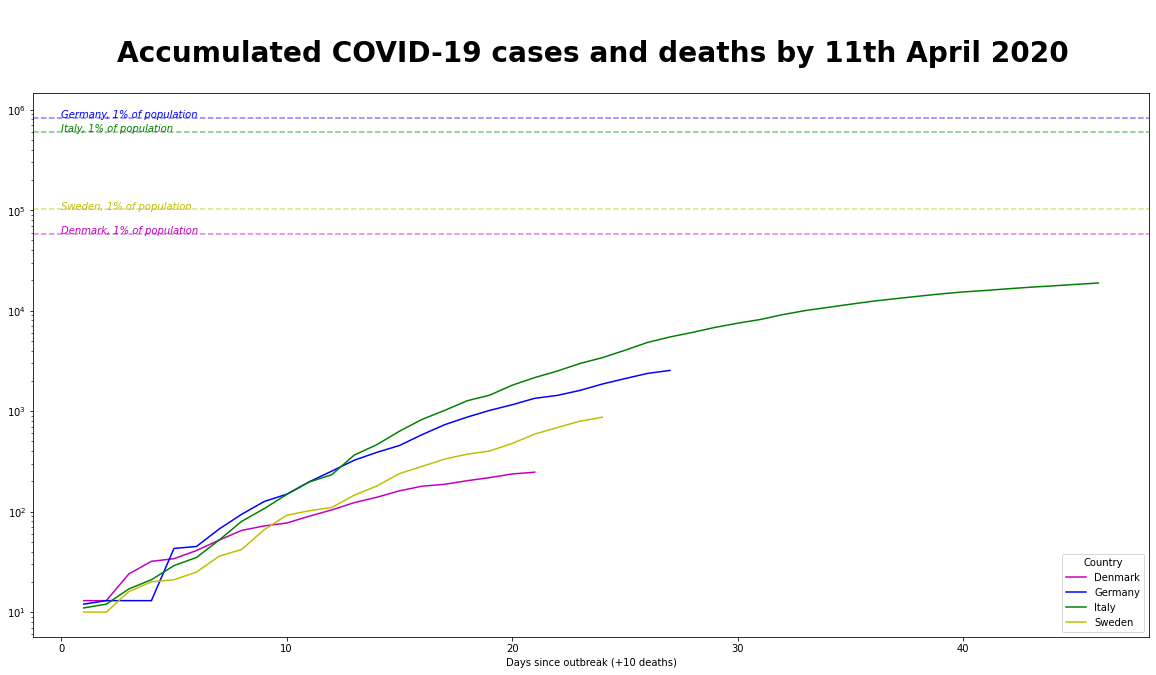

In [16]:
fig, ax = plt.subplots(
    figsize=(20, 10),
)

# Set figure title
fig.suptitle(
    '''
    Accumulated COVID-19 cases and deaths by 11th April 2020
    ''',
    fontsize=28,
    fontweight='bold',
    y=1
)

(
    df[(df['Country'].str.match('|'.join(selected_countries))) 
       & (df['Days since outbreak (+10 deaths)'] > 0)]
    .pivot_table(
        index='Days since outbreak (+10 deaths)',
        columns='Country',
        values='Accumulated Deaths'
    )
    .plot(
        logy=True,
        ax=ax,
        style={k:v[0] for k,v in country_style.items()}
    )
)
population_one_percents = {
    country : population / 100
    for country, population
    in df.loc[df['Country'].str.match('|'.join(selected_countries)),
              ['Country', 'Population (2018)']].values
}
for country in selected_countries:
    ax.axhline(
        population_one_percents[country],
        linestyle=country_style[country][1][1:],
        color=country_style[country][1][0],    
        alpha=0.5
    )
    ax.text(
        0,
        population_one_percents[country],
        f'{country}, 1% of population', 
        horizontalalignment='left',
        color=country_style[country][1][0],
        style='italic'
    )

## Have we learned anything at all?

To wrap things up and to end on a kind of positive note I would just like to show the below graph that hopefully gives some perspective over how dangerous this corona outbreak is for a common individual. I have almost started to believe that the scariest thing about this whole thing for people is the inevitability of it all. Of course the measures against the pandemic being issues by every country is helping, without them I would dare to say that we would be much worse of, but the fact that there is nothing that will totally stop this from happening is quite unsettling for most of us. 

But most of us will survive, and suprisingly maybe the biggest threat from the situation we are in now is not the COVID-19 syndrome itself but the socioeconomical effects that will be a results of it.

I don't want to downplay the risk for individuals in any of the risk groups or anyone that is suffering from the economical repercussions of this pandemic. 
But I also think that some perspective might be what is necessary to get through to the most of us. 

When someone that are comparatively healthy choses to skip washing their hands, "forget" to cough or sneeze into their elbow, or goes shopping with a runny nose it is because they are right when they think that they will probably be fine and nothing will happen to them. The reason we need to react is not to protect our selves but to protect the ones among us that won't be able to get back on their feet after a week or two in bed, or that doesn't have the luxury to work from home or transport themselves in their own car.

Since there are so many insecurities in the data and so many assumptions that are necessary to make questions that people feel their governments should be able to answer aren't as simple as they first might look to be. What I think is most important for all us right now is just to keep living, lockdown or not, trying to actively think about what we can do to prevent ourselves, or others, from falling ill. 

Try no to draw any quick conclusions from the numbers reported in the news because facing something like this there are no accepted truths. The only thing we can do is to stay calmy and try not to panic.